<a href="https://colab.research.google.com/github/PundirShivam/tradetest/blob/master/Money_Flow_Index_(_MSI_NSEpy_Python).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports
We will start by importing standard libraries including :

* pandas : data frame capabilites
* numpy  :  numerical computations
* Matplotlib.pyplot : will be used to plot the graphs
* NSEpy  : a wrapper to direclty return daily historical data from nse website in pandas dataframe 
* dateutil : this is utilied package will be used to convert string into date format

In [0]:
import pandas as pd
import numpy as np
#!pip install NSEpy
import nsepy 
from dateutil.parser import parse
import matplotlib.pyplot as plt
# warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
# stocks list we wish to analysze
# start date and end date in string format
stocks = ['HDFCBANK','ICICIBANK']
start = '1-1-2011'
end = '9-9-2019'

In [0]:
# writing a small function 
# to return the data frame  
def get_price(stocklist,start,end):
    """
    The function returns a pandas dataframe with 
    columns having name in list cols.
    It will return multi-index pandas data frame with cols column
    and time index and stocks in stocklist
    """
    cols = ['Open','High','Low','Close','Volume']
    price_df = pd.DataFrame()
    for stock in stocklist:
        temp = nsepy.get_history(symbol=stock,start=parse(start),end=parse(end))
        temp = temp[cols]
        idx = pd.MultiIndex.from_product([[stock],list(temp.index)])
        temp = pd.DataFrame(temp.values,index=idx,columns=cols)
        price_df = pd.concat([price_df,temp],axis=0)
    return price_df


In [0]:
# getting the price history of given stock and timeframe
price = get_price(stocks,start,end)

In [126]:
# selecting HDFCBANK price volume history
hdfc = price.loc['HDFCBANK'];hdfc.head()

,Open,High,Low,Close,Volume
2011-01-03,2370.0,2399.65,2350.4,2390.50,539839.0
2011-01-04,2386.5,2388.00,2333.0,2345.55,828413.0
2011-01-05,2349.7,2349.70,2297.5,2308.20,782592.0
2011-01-06,2316.0,2342.65,2309.0,2327.75,543509.0
2011-01-07,2326.2,2326.20,2261.0,2269.45,794801.0


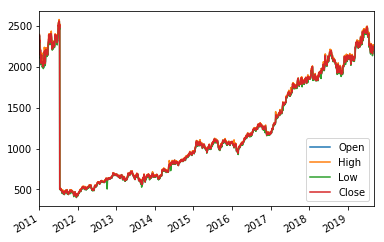

In [127]:
cols = hdfc.columns
hdfc[cols[:-1]].plot()

In [0]:
# limiting to 5 year period
# i.e. date above 2014
import datetime
baseyear = datetime.datetime(2014,1,1)
hdfc = hdfc[hdfc.index>baseyear]

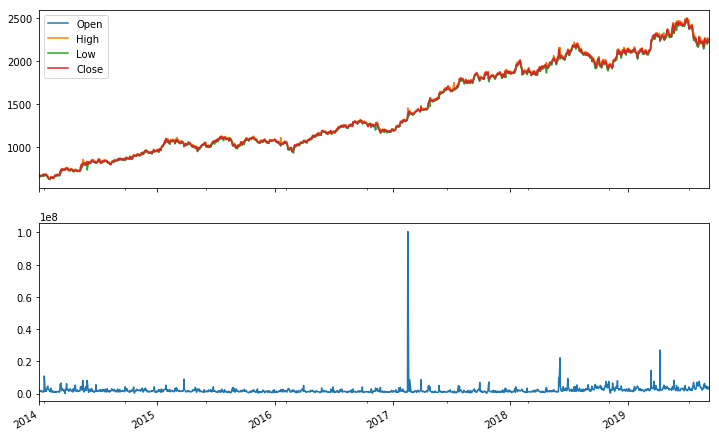

In [129]:
# plotting the graph and analyszing the 
fig, ax = plt.subplots(2,1,sharex=True,figsize=(12,8))
hdfc[hdfc.columns[:-1]].plot(ax=ax[0])
hdfc[hdfc.columns[-1]].plot(ax=ax[1])

# Money Flow Index (MSI)

 Refer to link :: https://www.investopedia.com/terms/m/mfi.asp
 
 Steps in calculating MSI (Refer Investopedia - above link):
1. Calculate the Typical Price for each of the last 14 periods.
 i.e. typical price = (High+Low+Close)/3
 
2. For each period, mark whether the typical price was higher or lower than the prior period. This will tell you whether Raw Money Flow is positive or negative.
 i.e. if  price (t) > price(t-1) return +1
      if price(t) < price(t-1) return -1

3. Calculate Raw Money Flow by multiplying the Typical Price by Volume for that period. Use negative or positive numbers depending on whether the period was up or down (see step above).
 i.e. row money flow = typical price X Volume

4. Calculate the Money Flow Ratio by adding up all the positive money flows over the last 14 periods and dividing it by the negative money flows for the last 14 periods.
 i.e. positive row money flow / negative row money flow 
    over last 14 periods

5. Calculate the Money Flow Index (MFI) using the ratio found in step four.
 i.e. MFI = 100 - 100/(1+Money Flow Ratio)

6. Continue doing the calculations as each new period ends, using only the last 14 periods of data.


In [0]:
def add_msi(data,period=14):
    """
    The function takes in the data frame with ohlc and volume data
    in with time indexed and default period of 14 days
    Output will be a input data frame with column name "msi" having msi values
    """
    df = data
    # step 1
    df['typical_price'] = (df['High']+df['Low']+df['Close'])/3
    # step 2 & step 3
    df['row_money_flow'] = np.sign((df['typical_price']-df['typical_price'].shift(1)).dropna(axis=0))*df['typical_price']*df['Volume']
    # step 4 
    df_pos = df['row_money_flow'].rolling(period).apply(lambda x:sum(x[x>0]))
    df_neg = df['row_money_flow'].rolling(period).apply(lambda x:sum(x[x<0]))
    df['money_flow_ratio'] = df_pos/np.abs(df_neg)
    # step 5
    data['money_flow_index'] = 100 - 100/(1+df['money_flow_ratio'])
    data = data.dropna(axis=0)
    data.drop(['typical_price','row_money_flow','money_flow_ratio'],inplace=True,axis=1)
    return data

Text(0.5, 1.0, 'Money Flow Index')

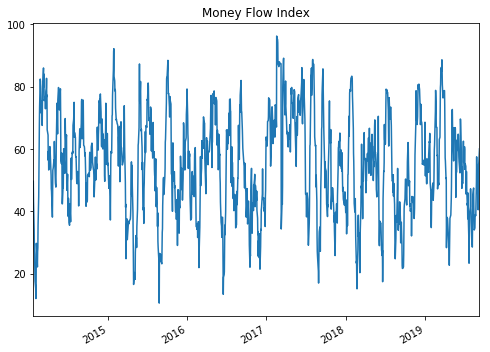

In [131]:
data = add_msi(hdfc,period=14)
data.money_flow_index.plot(figsize=(8,6))
plt.title('Money Flow Index')

In [0]:
# Now we have established the msi index
# lets create buy and sell signals based 
# on the requirement 
# SELL when MSI <= 30
# HOLD MSI 31-69
# BUY when MSI >= 70
def signal(value,up_limit,low_limit):    
    """
    The function returns takes in the MSI index value and returns
     +1 i.e. BUY signal for MSI > up_limit
     -1 i.e. SELL signal for MSI > low_limit
     0 i.e. HOLD signal for MSI > up_limit 
    """
    if value >= up_limit:
        return 1
    elif value <= low_limit:
        return -1
    else:
        return 0    
      
def calc_signals(data,up_limit=70,low_limit=30):
    """
    The function returns BUY and SELL signals 
    based on signal function.
    
    The function takes the diff of signals of 0's,-1's and 1's
    to come up with the absoulte buy and sell triggers
    """    
    data['signal'] = data['money_flow_index'].apply(lambda x:signal(x,up_limit,low_limit)) # generating the signal of 0's,1's and -1's
    data['signal'] = data['signal'].diff() # taking first difference
    data_clean = data.dropna(axis=0) # drop na values from dataframe
    return data_clean

def calc_pnl(data):
    sig_up = data['signal'].cumsum().apply(lambda x:x*(x>0)) # calculating only the places of upside
    sig_dwn = data['signal'].cumsum().apply(lambda x:x*(x<0)) # calculating only the places of downside
    pnl = np.cumsum(data['Close'].diff()*sig_up+data['Close'].diff()*sig_dwn) # cumulatively taking the price change and our position rebalance
    # pnl will return a time series
    return pnl
  
def cal_sharpe(pnl):
  
  """
  Function takes in the pnl of the signal
  and returns the sharpe ratio (annualized):
  
  Sharpe Ration = [ Rp - Rf)/ std(Rp) ]
  """
  abs_return = pnl.diff() # calculating the absolute daily returns
  abs_return = abs_return[~np.isinf(abs_return)] # removing indices where abs_return is inf
  sharpe = (np.nanmean(abs_return)/np.nanstd(abs_return))*np.sqrt(252) # sharpe ratio assuming a 252 days traing week
  return sharpe


def cal_ddwn(pnl):
  """
  The function returns the drawdown 
  i.e. the highest decline in value of the asset
  """
  hwm = 0  #high water mark to store the highest value reached till now
  ddwn = [] # for saving the draw down on the go
  for i in pnl:
    if i>hwm:
      hwm = i
    ddwn.append(i - hwm)
  return np.nanmin(ddwn)


def simulate_trade(data):
  # Function to tie it all together and simulate the backtest
  
  # Step 1: Creating buy and sell signals
  
  data = calc_signals(data,70,30)
  
  # Step 2: Calculting PNL
  
  pnl = calc_pnl(data)
  
  # Step 3: Calculating Sharep and Ddwn
  
  sharpe = cal_sharpe(pnl)
  ddwn = cal_ddwn(pnl)
  
  fig = plt.figure(figsize=(7,5))
  plt.plot(pnl.index,pnl.values,label='(Rs.) pnl')
  #data.Close.plot(ax=ax[0],label='Close Price')
  plt.legend()
  plt.tight_layout(True)
  print("\n Final P&L: {0:.2f}".format(pnl[-1]),
       '\n',
       "Sharpe Ratio: {0:.2f}".format(sharpe),
       '\n',
       'Max. Drawdown: {0:.2f}'.format(ddwn)) 
  
  return pnl,ddwn,sharpe


 Final P&L: 1481.75 
 Sharpe Ratio: 2.00 
 Max. Drawdown: -90.65


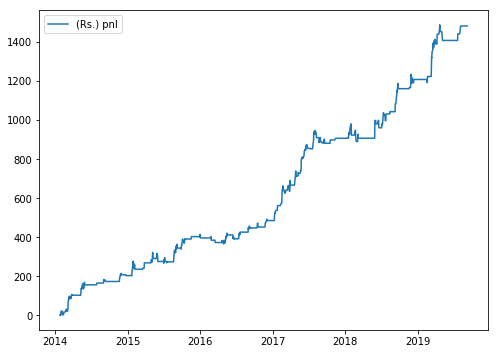

In [143]:
pnl, ddwm, sharpe  = simulate_trade(data)